In [1]:
#Mounting google and authenticating
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


In [2]:
!cp /mydrive/music\ project/X_spec.pickle ./
!cp /mydrive/music\ project/y_spec.pickle ./

In [3]:
#LOADING DATA
import pickle 
pickle_off = open("X_spec.pickle", 'rb')
X_spec = pickle.load(pickle_off)

pickle_off = open("y_spec.pickle", 'rb')
y_spec = pickle.load(pickle_off)

In [4]:
# For visual
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
from IPython import display
import tensorflow as tf

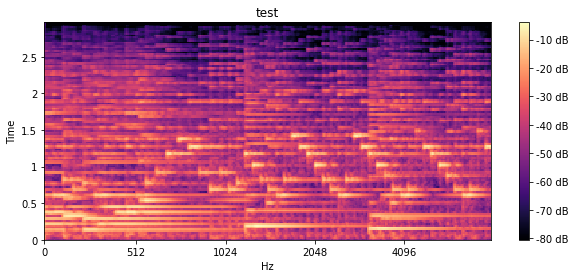

In [ ]:
  genre_name = 'test'
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(X_spec[5].T, y_axis='time', fmax=8000, x_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(str(genre_name))
  plt.show()

In [ ]:
import scipy
from scipy.io.wavfile import write
import numpy as np


sr=22050
t = X_spec[5]
audio_path = '/content/audio/test3.wav'
wav = librosa.db_to_power(t.T, ref=1.0)
wav = librosa.feature.inverse.mel_to_audio (M=wav, hop_length=512, sr=sr)
wav *= 32767 / max (0.01, np.max(np.abs(wav)))
write (audio_path, sr, wav.astype(np.int16))
#write (audio_path, sr, wav.astype(np.float32))

In [5]:
#Normalize

X_spect = (X_spec.astype('float32') - 100) /116
y_spect = (y_spec.astype('float32') - 100) /116

In [6]:
# train and split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_spect, y_spect, test_size=0.1, random_state=42)

In [14]:
import numpy as np

print(X_train.shape)
print(X_test.shape)
train = np.array([X_train, y_train])
test = np.array([X_test, y_test])
print(train.shape)
print(test.shape)
train = train.reshape(2,1287,300,128,1)
test = test.reshape(2,144,300,128,1)
print(train.shape)
print(test.shape)

(1287, 300, 128)
(144, 300, 128)
(2, 1287, 300, 128)
(2, 144, 300, 128)
(2, 1287, 300, 128, 1)
(2, 144, 300, 128, 1)


In [15]:
train_size = 1287
batch_size = 32
test_size = 144

#train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 #.shuffle(train_size).batch(batch_size))
train_dataset = (tf.data.Dataset.from_tensor_slices(train)
                 .batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test)
                .batch(batch_size))

In [16]:
def normalize_test(input_image, input_mask):
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

train_dataset = train_dataset.map(load_image_test)

In [17]:
def normalize_test(input_image, input_mask):
    input_image = tf.image.grayscale_to_rgb(input_image)  
    input_mask = tf.image.grayscale_to_rgb(input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image, input_mask = normalize_test(datapoint[0], datapoint[1])
    return input_image, input_mask

test_dataset = test_dataset.map(load_image_test)

In [18]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(train[1,1], 0))
print (down_result.shape)

(1, 150, 64, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 300, 128, 3)
